# 1) Import the required Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

import statsmodels.api as sm
import numpy as np
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/Users/mahendra/.pyenv/versions/3.9.7/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# 2) Read the Data and do EDA

1. Read the Fundamental data from csv
2. Change the data type of date and make it as index
3. Keep only the series that we are interested in
4. Start the data from 2010
5. Plot the input series

In [2]:
df_aapl = pd.read_csv('../data/AAPL_FundamentalData.csv', parse_dates=['index'], infer_datetime_format=True)
df_aapl.set_index('index', inplace=True)
df_aapl.index.names = ['Date']

df_aapl = df_aapl[['revenuePerShare']]
df_aapl = df_aapl.loc['2010':]
df_aapl.fillna(method='ffill', inplace=True)

df_aapl.tail()

,revenuePerShare
Date,
2020-06-30,3.459941
2020-09-30,3.792909
2020-12-31,6.580349
2021-03-31,5.347189
2021-06-30,4.896998


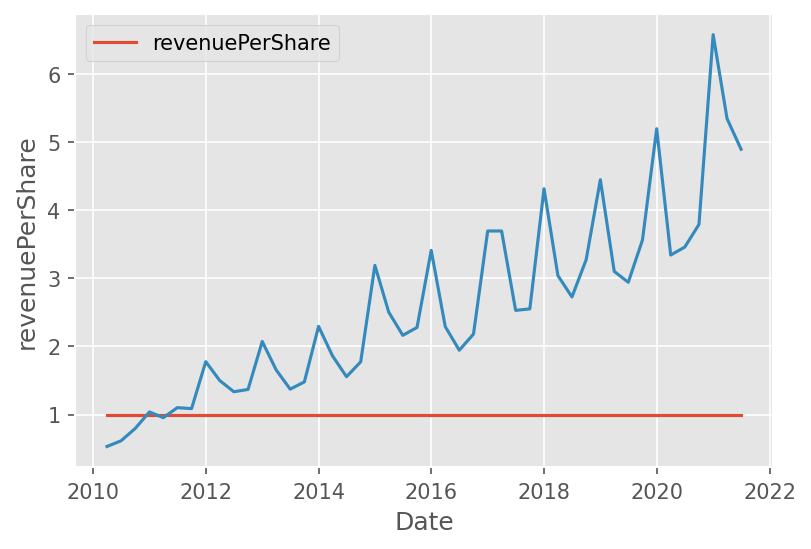

In [38]:
plt.plot(df_aapl)
plt.xlabel('Date')
plt.ylabel('revenuePerShare')
plt.legend(['revenuePerShare'])


# 3) Linear Regression Model

1. Build a linear regression model on the input time series
2. Get the predictions from the model
3. Plot the input series and the model preds

## Linear regression and preds

In [3]:
df_aapl = sm.add_constant(df_aapl)
df_aapl['Date'] = np.arange(df_aapl.shape[0])

In [4]:
df_aapl.tail()

,const,revenuePerShare,Date
Date,,,
2020-06-30,1.0,3.459941,41
2020-09-30,1.0,3.792909,42
2020-12-31,1.0,6.580349,43
2021-03-31,1.0,5.347189,44
2021-06-30,1.0,4.896998,45


In [6]:
x_train = df_aapl.drop('revenuePerShare', axis=1).copy()
y_train = df_aapl['revenuePerShare'].copy()

lin_model = sm.OLS(y_train, x_train).fit()
print(lin_model.summary())
preds = lin_model.fittedvalues

                            OLS Regression Results                            
Dep. Variable:        revenuePerShare   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     152.5
Date:                Thu, 03 Feb 2022   Prob (F-statistic):           6.82e-16
Time:                        11:59:16   Log-Likelihood:                -44.533
No. Observations:                  46   AIC:                             93.07
Df Residuals:                      44   BIC:                             96.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5699      0.189      3.015      0.0

## Plot the input series and model preds

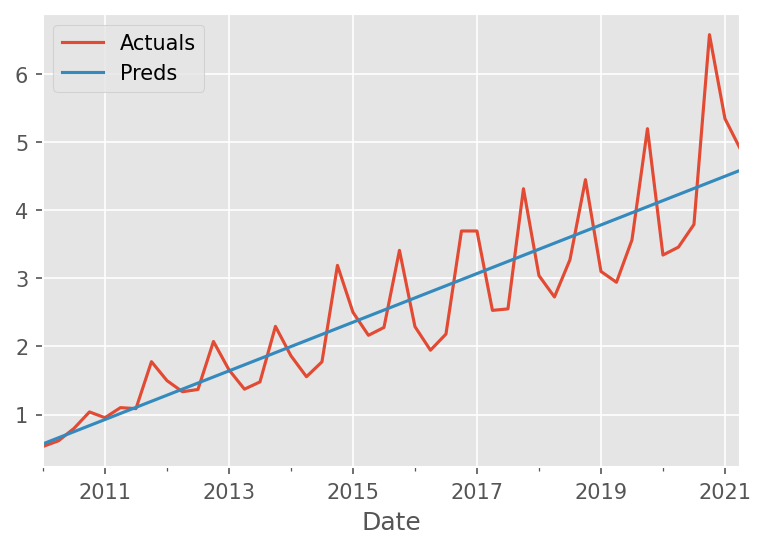

In [7]:
df_aapl['revenuePerShare'].plot()
preds.plot()

plt.legend(['Actuals', 'Preds'])
plt.show()

# 4) Multiplicative seasonality adjustment factor

1. Create a series of month names from the date
2. Create a series of multiplicative error(inverse of prediction error%)
3. Combine the month names and error into a dataframe
4. Groupby the month and find the mean of the error to get the multiplicative seasonality adjustment factor

## Seasonality

In [8]:
seasonality = pd.Series(df_aapl.index.month_name(), index=df_aapl.index)
errors = pd.Series(df_aapl['revenuePerShare']/preds, index=df_aapl.index)

## Multiplicative Error

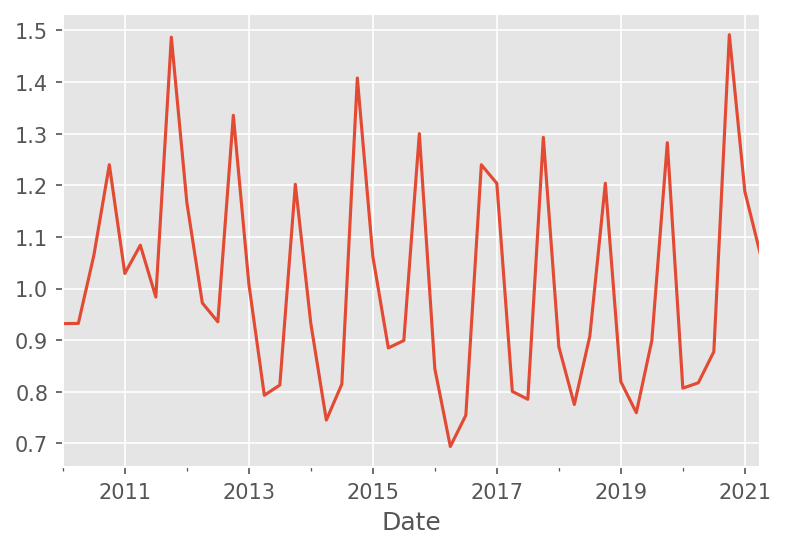

In [9]:
errors.plot()
plt.show()

## Multiplicative adjustment factor

In [10]:
df_mult = pd.concat([seasonality, errors], axis=1)
df_mult.columns = ['seasonality', 'seasonality_mul_factor']
df_mult = df_mult.groupby('seasonality')['seasonality_mul_factor'].mean()
df_mult = pd.DataFrame(df_mult).reset_index()
df_mult

,seasonality,seasonality_mul_factor
0,December,1.316677
1,June,0.860484
2,March,0.990206
3,September,0.885019


# 5) Additive seasonality adjustment factor

1. Create a series of additive error(inputseries - preds)
2. Combine the month names and error into a dataframe
3. Groupby the month and find the mean of the error to get the additive seasonality adjustment factor

## Additive Error

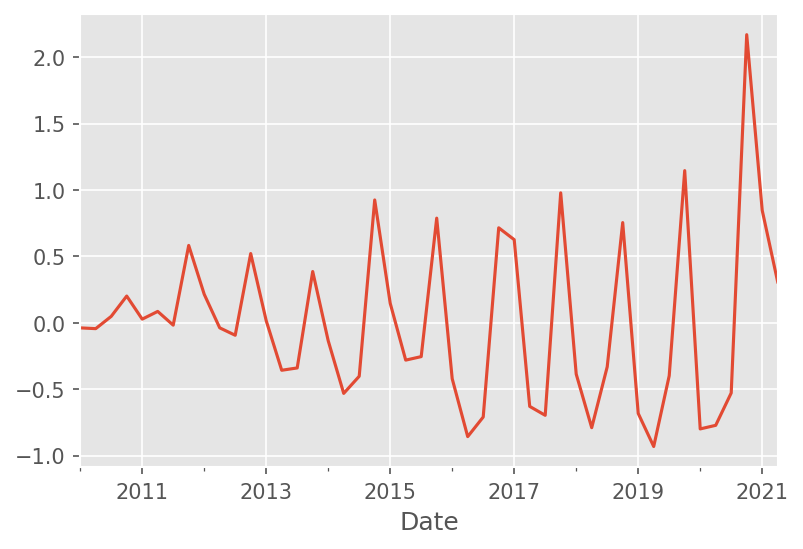

In [11]:
adt_errors = pd.Series(df_aapl['revenuePerShare'] - preds, index=df_aapl.index)

adt_errors.plot()
plt.show()

## Additive adjustment factor

In [12]:
df_adt = pd.concat([seasonality, adt_errors], axis=1)
df_adt.columns = ['seasonality', 'seasonality_adt_factor']
df_adt = df_adt.groupby('seasonality')['seasonality_adt_factor'].mean()
df_adt = pd.DataFrame(df_adt).reset_index()
df_adt

,seasonality,seasonality_adt_factor
0,December,0.833085
1,June,-0.403679
2,March,-0.049085
3,September,-0.339161


# 6) Adjust the linear regression preds for additive and multiplicative seasonality

1. Create a dataframe of input series, linear regression & predictions
2. Get the additive and multiplicative adjustment factors for all rows
3. Multiply the linear reg preds with multiplicative factor
4. Add the linear reg preds with additive factor
5. Plot the input series and linear reg preds with adjusted values

## Actuals, Predictions and Seasonality

In [101]:
df_aps = pd.concat([df_aapl['revenuePerShare'], preds, seasonality], axis=1)
df_aps.columns = ['revenuePerShare', 'lin_reg_preds', 'seasonality']
df_aps.head()

,revenuePerShare,lin_reg_preds,seasonality
Date,,,
2010-03-31,0.531219,0.569885,March
2010-06-30,0.614686,0.659215,June
2010-09-30,0.796468,0.748546,September
2010-12-31,1.038880,0.837876,December
2011-03-31,0.954255,0.927207,March


## Seasonality factors

In [102]:
df_aps = df_aps.reset_index().merge(df_mult, on='seasonality', how='left').set_index(df_aps.index.names)
df_aps = df_aps.reset_index().merge(df_adt, on='seasonality', how='left').set_index(df_aps.index.names)

In [104]:
df_aps.tail()

,revenuePerShare,lin_reg_preds,seasonality,seasonality_mul_factor,seasonality_adt_factor
Date,,,,,
2020-06-30,3.459941,4.232434,June,0.860484,-0.403679
2020-09-30,3.792909,4.321764,September,0.885019,-0.339161
2020-12-31,6.580349,4.411095,December,1.316677,0.833085
2021-03-31,5.347189,4.500425,March,0.990206,-0.049085
2021-06-30,4.896998,4.589756,June,0.860484,-0.403679


## Seasonality adjustments

In [111]:
df_aps['adj_mult'] = df_aps['lin_reg_preds'] * df_aps['seasonality_mul_factor']
df_aps['adj_adt'] = df_aps['lin_reg_preds'] + df_aps['seasonality_adt_factor']

df_aps.tail()

,revenuePerShare,lin_reg_preds,seasonality,seasonality_mul_factor,seasonality_adt_factor,adj_mult,adj_adt
Date,,,,,,,
2020-06-30,3.459941,4.232434,June,0.860484,-0.403679,3.641943,3.828755
2020-09-30,3.792909,4.321764,September,0.885019,-0.339161,3.824845,3.982603
2020-12-31,6.580349,4.411095,December,1.316677,0.833085,5.807985,5.244180
2021-03-31,5.347189,4.500425,March,0.990206,-0.049085,4.456347,4.451340
2021-06-30,4.896998,4.589756,June,0.860484,-0.403679,3.949413,4.186077


## Post adjustment preds and actuals plot

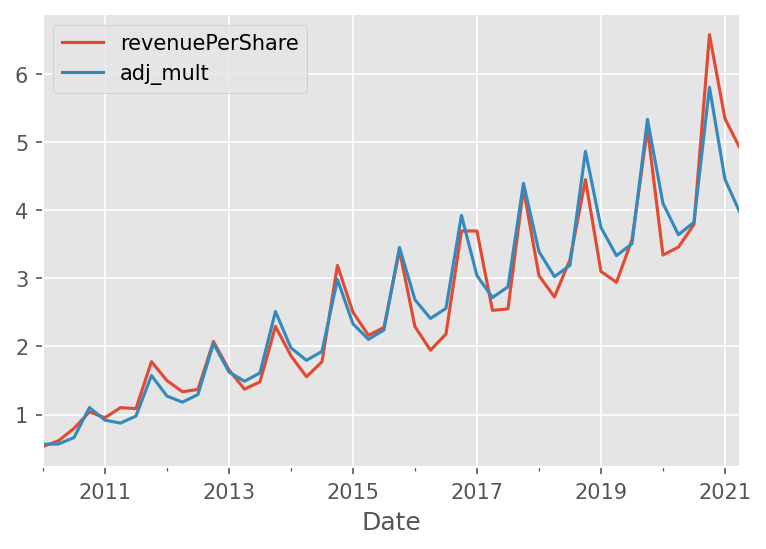

In [115]:
df_aps[['revenuePerShare', 'adj_mult']].plot()
plt.show()

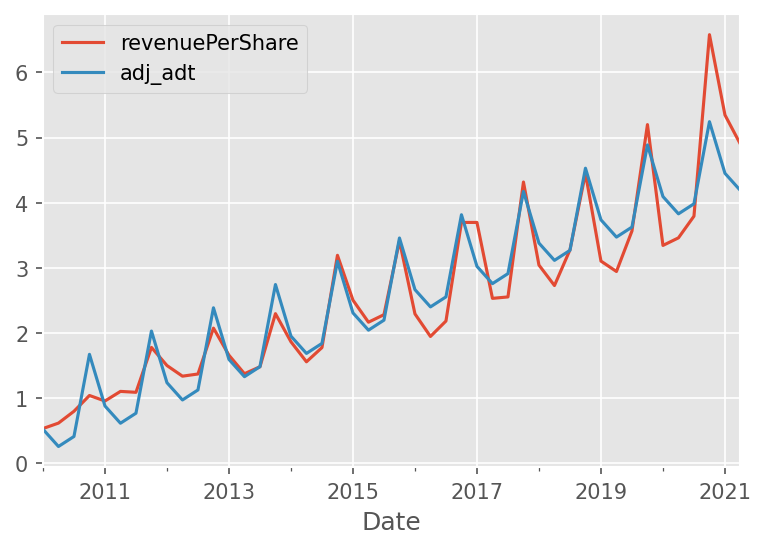

In [116]:
df_aps[['revenuePerShare', 'adj_adt']].plot()
plt.show()

# 7) Add Confidence intervals to the predictions

1. From the result of the model get the confidence intervals
2. Attach the input series along with additive and multiplicative seasonality factors to the confidence intervals
3. Get the multiplicative adjusted upper and lower boundaries
4. Get the additive adjusted upper and lower boundaries
5. Plot the actual and predictions along with the boundaries

## Confidence intervals of predictions

In [121]:
predictions = lin_model.get_prediction(x_train)
conf_intv_vals = predictions.summary_frame()
conf_intv_vals = conf_intv_vals[['obs_ci_lower','obs_ci_upper']]
conf_intv_vals.tail()

,obs_ci_lower,obs_ci_upper
Date,,
2020-06-30,2.878265,5.586603
2020-09-30,2.964616,5.678913
2020-12-31,3.050817,5.771372
2021-03-31,3.136870,5.863981
2021-06-30,3.222774,5.956737


## Attach the adjustment factors

In [122]:
conf_intv_vals = pd.merge(conf_intv_vals, df_aps[['revenuePerShare', 'seasonality_mul_factor', 'seasonality_adt_factor']], left_index=True, right_index=True)

In [123]:
conf_intv_vals.tail()

,obs_ci_lower,obs_ci_upper,revenuePerShare,seasonality_mul_factor,seasonality_adt_factor
Date,,,,,
2020-06-30,2.878265,5.586603,3.459941,0.860484,-0.403679
2020-09-30,2.964616,5.678913,3.792909,0.885019,-0.339161
2020-12-31,3.050817,5.771372,6.580349,1.316677,0.833085
2021-03-31,3.136870,5.863981,5.347189,0.990206,-0.049085
2021-06-30,3.222774,5.956737,4.896998,0.860484,-0.403679


## Get the multiplicative adjusted values

In [125]:
conf_intv_vals['adj_multiplicative_ub'] = conf_intv_vals['obs_ci_upper'] * conf_intv_vals['seasonality_mul_factor']
conf_intv_vals['adj_multiplicative_lb'] = conf_intv_vals['obs_ci_lower'] * conf_intv_vals['seasonality_mul_factor']
conf_intv_vals.tail()

,obs_ci_lower,obs_ci_upper,revenuePerShare,seasonality_mul_factor,seasonality_adt_factor,adj_multiplicative_ub,adj_multiplicative_lb
Date,,,,,,,
2020-06-30,2.878265,5.586603,3.459941,0.860484,-0.403679,4.807185,2.476702
2020-09-30,2.964616,5.678913,3.792909,0.885019,-0.339161,5.025948,2.623743
2020-12-31,3.050817,5.771372,6.580349,1.316677,0.833085,7.599031,4.016939
2021-03-31,3.136870,5.863981,5.347189,0.990206,-0.049085,5.806548,3.106147
2021-06-30,3.222774,5.956737,4.896998,0.860484,-0.403679,5.125679,2.773147


## Get the additive adjusted values

,obs_ci_lower,obs_ci_upper,revenuePerShare,seasonality_factor_multi,seasonality_factor_add,adj_multiplicative_ub,adj_multiplicative_lb,adj_additive_ub,adj_additive_lb
Date,,,,,,,,,
2020-06-30,2.851583,5.560909,3.459941,0.868992,-0.387706,4.832386,2.478003,5.173203,2.463877
2020-09-30,2.940222,5.655742,3.792909,0.892487,-0.325648,5.047675,2.624110,5.330094,2.614574
2020-12-31,3.028701,5.750735,6.580349,1.324152,0.844194,7.614845,4.010460,6.594928,3.872895
2021-03-31,3.117022,5.845886,5.347189,0.981173,-0.095594,5.735825,3.058337,5.750292,3.021428
2021-06-30,3.205185,5.941195,4.896998,0.868992,-0.387706,5.162851,2.785280,5.553489,2.817479


## Multiplicative adjusted values with confidence intervals

,adj_multiplicative_ub,adj_multiplicative_lb,revenuePerShare,adj_multiplicative
Date,,,,
2020-06-30,4.832386,2.478003,3.459941,3.655194
2020-09-30,5.047675,2.624110,3.792909,3.835892
2020-12-31,7.614845,4.010460,6.580349,5.812653
2021-03-31,5.735825,3.058337,5.347189,4.397081
2021-06-30,5.162851,2.785280,4.896998,3.974065


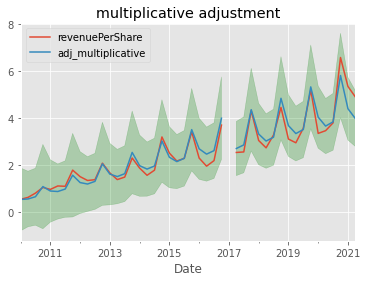

## Additive adjusted values with confidence intervals

,adj_additive_ub,adj_additive_lb,revenuePerShare,adj_additive
Date,,,,
2020-06-30,5.173203,2.463877,3.459941,3.818540
2020-09-30,5.330094,2.614574,3.792909,3.972334
2020-12-31,6.594928,3.872895,6.580349,5.233912
2021-03-31,5.750292,3.021428,5.347189,4.385860
2021-06-30,5.553489,2.817479,4.896998,4.185484


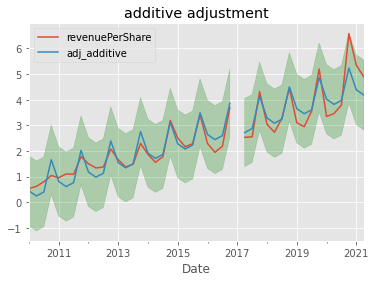

# 8) Test predictions

1. Create a dataframe of future dates and actual values of test
2. Get the linear regression preds
3. Get the adjustment factors
4. Get the adjusted values
5. Plot the actual and preds of train and test

## Test data frame with future dates and actual values

,revenuePerShare_test
2021-09-30,5.056
2021-12-31,7.518
2022-03-31,NaN
2022-06-30,NaN
2022-09-30,NaN


## Linear regression preds

,const,revenuePerShare_test
2021-09-30,1.0,5.056
2021-12-31,1.0,7.518
2022-03-31,1.0,NaN
2022-06-30,1.0,NaN
2022-09-30,1.0,NaN


,const,revenuePerShare_test,Date
2021-09-30,1.0,5.056,45
2021-12-31,1.0,7.518,46
2022-03-31,1.0,NaN,47
2022-06-30,1.0,NaN,48
2022-09-30,1.0,NaN,49


,const,revenuePerShare_test,Date,revenuePerShare_pred
2021-09-30,1.0,5.056,45,4.664926
2021-12-31,1.0,7.518,46,4.756662
2022-03-31,1.0,NaN,47,4.848398
2022-06-30,1.0,NaN,48,4.940133
2022-09-30,1.0,NaN,49,5.031869


## Adjustment factors & Adjusted values

,const,revenuePerShare_test,Date,revenuePerShare_pred,seasonality
2021-09-30,1.0,5.056,45,4.664926,September
2021-12-31,1.0,7.518,46,4.756662,December
2022-03-31,1.0,NaN,47,4.848398,March
2022-06-30,1.0,NaN,48,4.940133,June
2022-09-30,1.0,NaN,49,5.031869,September


### Multiplicative adjustment

,index,const,revenuePerShare_test,Date,revenuePerShare_pred,seasonality,seasonality_factor_multi,adj_multiplicative_test
0,2021-09-30,1.0,5.056,45,4.664926,September,0.892487,4.163385
1,2021-12-31,1.0,7.518,46,4.756662,December,1.324152,6.298542
2,2022-03-31,1.0,NaN,47,4.848398,March,0.981173,4.757116
3,2022-06-30,1.0,NaN,48,4.940133,June,0.868992,4.292937
4,2022-09-30,1.0,NaN,49,5.031869,September,0.892487,4.490877


### Additive adjustment

,index,const,revenuePerShare_test,Date,revenuePerShare_pred,seasonality,seasonality_factor_multi,adj_multiplicative_test,seasonality_factor_add,adj_additive_test
0,2021-09-30,1.0,5.056,45,4.664926,September,0.892487,4.163385,-0.325648,4.339278
1,2021-12-31,1.0,7.518,46,4.756662,December,1.324152,6.298542,0.844194,5.600855
2,2022-03-31,1.0,NaN,47,4.848398,March,0.981173,4.757116,-0.095594,4.752804
3,2022-06-30,1.0,NaN,48,4.940133,June,0.868992,4.292937,-0.387706,4.552427
4,2022-09-30,1.0,NaN,49,5.031869,September,0.892487,4.490877,-0.325648,4.706222


## Plot of actual and preds of train and test

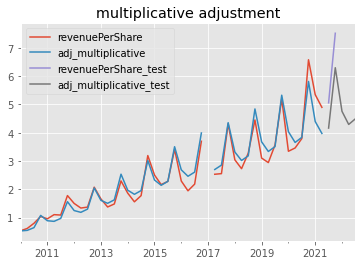

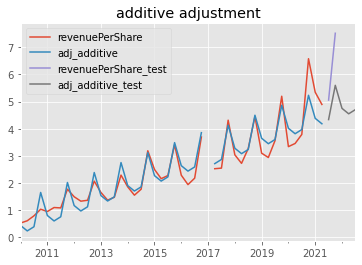

# 9) Time Series decomposition

## Nifty daily data

## Decomposition of nifty data

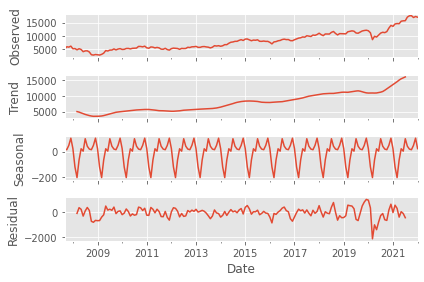

### Only trend component

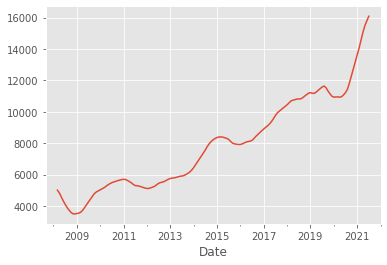

### Only seasonality component

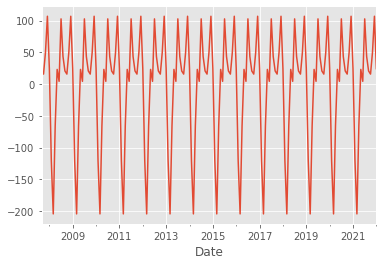

## Auto Correlation (ACF)

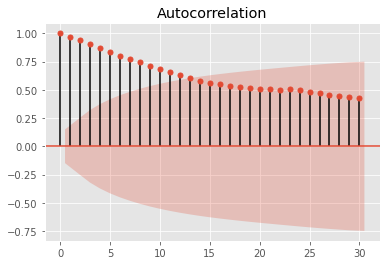

## Partial Auto Correlation (PACF)

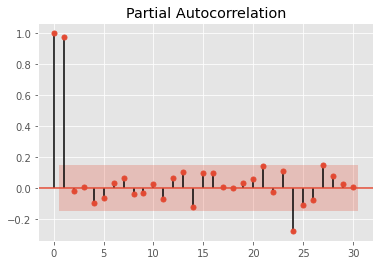